# 📌 LAB 10 – IMAGE COMPRESSION (Python – Google Colab)

## In this lab, JPEG-like image compression is performed by first converting the input grayscale image into fixed-size 8×8 blocks after padding the image dimensions to multiples of eight.
## Each block is level-shifted and transformed into the frequency domain using the two-dimensional Discrete Cosine Transform (DCT). The resulting DCT coefficients are then quantized using a standard JPEG quantization matrix to achieve compression by reducing high-frequency components.
## The compressed image is reconstructed by de-quantizing the coefficients, applying the inverse DCT, and removing the padded regions to restore the original image size.
## The performance of the compression is evaluated by computing the Mean Squared Error (MSE), Peak Signal-to-Noise Ratio (PSNR), Compression Ratio (CR), and Rate–Distortion (RD).
## Finally, the original and compressed images are visually compared to analyze the trade-off between image quality and compression efficiency.

(np.float64(-0.5), np.float64(320.5), np.float64(321.5), np.float64(-0.5))

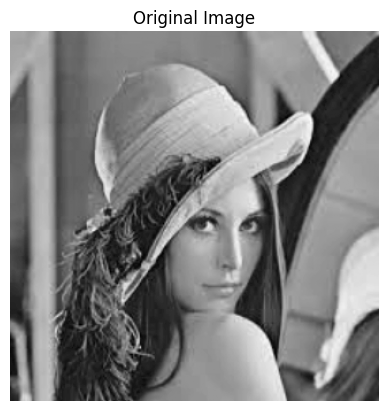

In [1]:
# 🔹 Imports & Image Loading
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq
from scipy.fftpack import dct, idct

# Load image (grayscale)
img = cv2.imread('/content/Lena.png', cv2.IMREAD_GRAYSCALE)

if img is None:
    raise ValueError("Image not found. Upload Lena.png to Colab!")

plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

In [2]:

# 🔹 Utility Functions (Metrics)

def mse(original, compressed):
    return np.mean((original - compressed) ** 2)

def psnr(original, compressed):
    m = mse(original, compressed)
    if m == 0:
        return float('inf')
    return 20 * np.log10(255 / np.sqrt(m))

def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size


# TASK 1 – Huffman Coding Implementation

In [3]:
# Huffman Tree
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

In [4]:
# Build Huffman Codes
def build_huffman_tree(data):
    freq = Counter(data.flatten())
    heap = [HuffmanNode(sym, fr) for sym, fr in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        parent = HuffmanNode(freq=n1.freq + n2.freq)
        parent.left = n1
        parent.right = n2
        heapq.heappush(heap, parent)

    return heap[0]

def generate_codes(node, prefix="", codebook={}):
    if node is None:
        return
    if node.symbol is not None:
        codebook[node.symbol] = prefix
    generate_codes(node.left, prefix + "0", codebook)
    generate_codes(node.right, prefix + "1", codebook)
    return codebook

In [5]:
# Encode Image
tree = build_huffman_tree(img)
codes = generate_codes(tree)

encoded_bits = ''.join([codes[p] for p in img.flatten()])
original_bits = img.size * 8
compressed_bits = len(encoded_bits)

CR_huffman = compression_ratio(original_bits, compressed_bits)

# TASK 2 – JPEG-like DCT Compression

In [9]:

# DCT & IDCT Functions
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')


In [10]:
# Quantization Matrix (JPEG Standard)
Q = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])


In [11]:
# Padding Image to Multiple of 8
h, w = img.shape
pad_h = (8 - h % 8) % 8
pad_w = (8 - w % 8) % 8

img_padded = np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant')
hp, wp = img_padded.shape

In [12]:
# DCT Compression & Reconstruction
compressed = np.zeros((hp, wp))
reconstructed = np.zeros((hp, wp))

for i in range(0, hp, 8):
    for j in range(0, wp, 8):
        block = img_padded[i:i+8, j:j+8] - 128
        dct_block = dct2(block)
        q_block = np.round(dct_block / Q)
        compressed[i:i+8, j:j+8] = q_block
        reconstructed[i:i+8, j:j+8] = idct2(q_block * Q) + 128

In [13]:
# Crop & Final Image
reconstructed = reconstructed[:h, :w]
reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

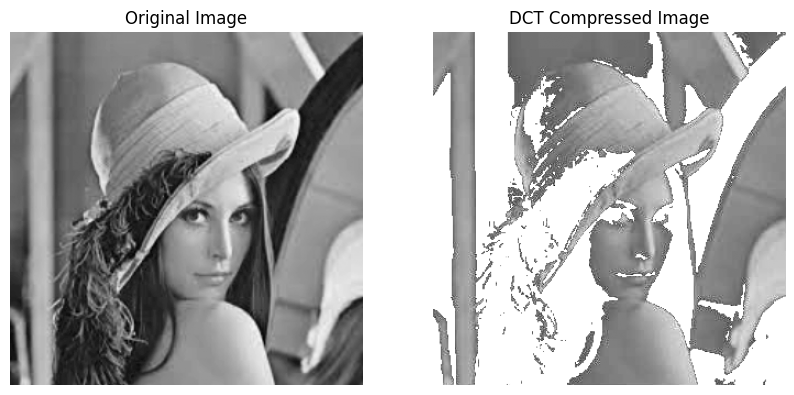

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed, cmap='gray')
plt.title("DCT Compressed Image")
plt.axis('off')

plt.show()


# ✅ TASK 3 – METRICS (CR, MSE, PSNR, RD)

In [15]:
# 🔹 Metric Functions
def mse(original, compressed):
    return np.mean((original - compressed) ** 2)

def psnr(original, compressed):
    m = mse(original, compressed)
    if m == 0:
        return float('inf')
    return 20 * np.log10(255 / np.sqrt(m))

def compression_ratio(original_pixels, nonzero_coeffs):
    return original_pixels / nonzero_coeffs


In [16]:
# Compute Metrics
MSE = mse(img, reconstructed)
PSNR = psnr(img, reconstructed)

nonzero = np.count_nonzero(compressed)
CR = compression_ratio(img.size, nonzero)

RD = MSE / CR

In [17]:
# Display Values
print("----- DCT Compression Metrics -----")
print(f"MSE  : {MSE:.2f}")
print(f"PSNR : {PSNR:.2f} dB")
print(f"CR   : {CR:.2f}")
print(f"RD   : {RD:.4f}")

----- DCT Compression Metrics -----
MSE  : 58.56
PSNR : 30.45 dB
CR   : 4.14
RD   : 14.1498


# TASK 4 – ORIGINAL vs COMPRESSED IMAGE

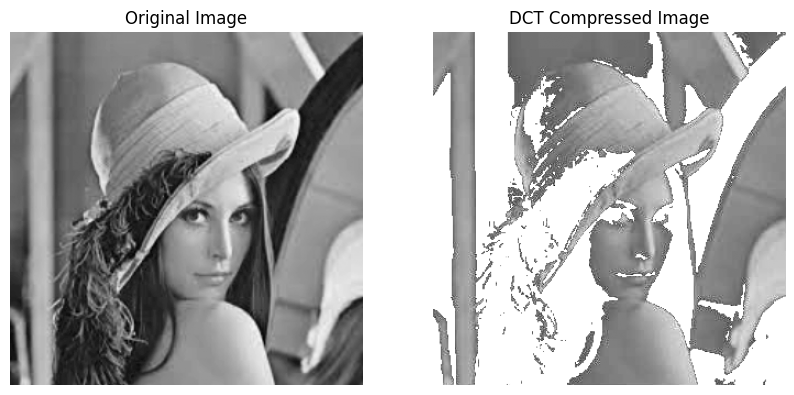

In [18]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed, cmap='gray')
plt.title("DCT Compressed Image")
plt.axis('off')

plt.show()
